## Orphan molecules and their coefficient of variation

Consider a specific marker gene for a cell type. If orphan molecules are (in part) unphysical and uncorrelated with real cell transcriptional states, we expect "orphan markers" to be less specific. In other words, we expect a smaller coefficient of variation.

In [4]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
from typing import List, Set, Dict, Tuple, Union
from commons import *

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

In [2]:
# select dataset
mol_h5_path = '/Users/mehrtash/Data/10x/pbmc4k_molecule_info.h5'
genes_tsv_path = None

In [3]:
mol_info = MoleculeInfo(mol_h5_path, genes_tsv_path)

## Helper Methods

In [13]:
# extract barcode index ranges
barcode_start_indices = []
sorted_barcodes = []
for barcode, records in itertools.groupby(enumerate(mol_info.barcode_array), operator.itemgetter(1)):
    first_index = next(records)[0]
    barcode_start_indices.append(first_index)
    sorted_barcodes.append(barcode)
barcode_start_indices.append(len(mol_info.barcode_array))
barcode_to_index_dict = {barcode: index for index, barcode in enumerate(sorted_barcodes)}

def get_barcode_index_range(barcode: int) -> Tuple[int, int]:
    barcode_index = barcode_to_index_dict[barcode]
    return (barcode_start_indices[barcode_index], barcode_start_indices[barcode_index + 1])

In [4]:
# select a range of barcodes
min_umi_count = 1_000
max_umi_count = 50_000
cell_barcode_set = {barcode for barcode, total_umi in mol_info.total_umi_per_barcode.items()
                    if min_umi_count <= total_umi <= max_umi_count}
print(f'Selected {len(cell_barcode_set)} barcodes in range ({min_umi_count}, {max_umi_count})')

Selected 4481 barcodes in range (1000, 50000)


In [8]:
full_umi_count_stats = get_full_umi_count_statistics(
    cell_barcode_set, mol_info.gene_array, mol_info.reads_array, mol_info.barcode_array)

In [62]:
gene_index_sorted_by_expression = get_gene_index_sorted_by_expression(full_umi_count_stats)

In [66]:
marker_gene_names = [
    b'LEF1',
    b'S100A12',
    b'VPREB3',
    b'IGHD',
    b'LINC00926']

gene_name_to_idx = {gene_name: idx for idx, gene_name in enumerate(mol_info.gene_names_array)}
marker_gene_indices = list(gene_name_to_idx[gene_name] for gene_name in marker_gene_names)

Observations with family size <= 1 for gene LEF1: 13.2%
Observations with family size <= 1 for gene S100A12: 9.4%
Observations with family size <= 1 for gene VPREB3: 7.0%
Observations with family size <= 1 for gene IGHD: 10.1%
Observations with family size <= 1 for gene LINC00926: 28.2%


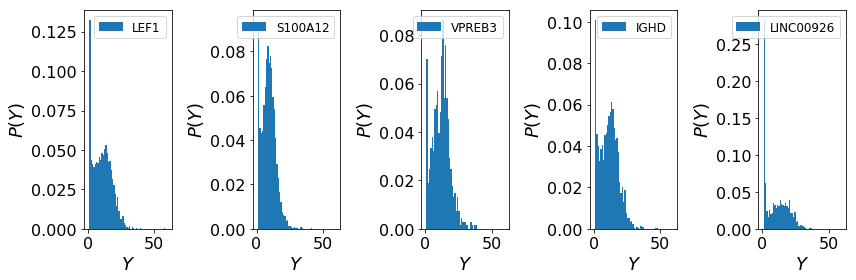

In [10]:
plot_umi_hist_for_genes(marker_gene_names, mol_info.gene_names_array, full_umi_count_stats)

In [34]:
def get_gene_expression_for_family_size(cell_barcode_list: List[int], gene_index: int,
                                        family_size: int,
                                        mol_info: MoleculeInfo,
                                        cond_type: str = 'eq'):
    gene_expr_list = []
    for barcode in cell_barcode_list:
        barcode_start_index, barcode_end_index = get_barcode_index_range(barcode)
        barcode_reads = mol_info.reads_array[barcode_start_index:barcode_end_index]
        barcode_genes = mol_info.gene_array[barcode_start_index:barcode_end_index]
        if cond_type == 'eq':
            cond_fs = barcode_reads == family_size
        elif cond_type == 'lte':
            cond_fs = barcode_reads <= family_size
        elif cond_type == 'gte':
            cond_fs = barcode_reads >= family_size
        else:
            raise Exception('Unknown condition type!')
        expression = np.sum(cond_fs & (barcode_genes == gene_index))
        gene_expr_list.append(expression)
    return gene_expr_list

In [35]:
cell_barcode_list = list(cell_barcode_set)

In [58]:
def cv(vals):
    mean, std = np.mean(vals), np.std(vals) 
    return std / mean, mean

In [96]:
gene_indices = gene_index_sorted_by_expression[1:10000]

orphan_cv_list = []
orphan_mean_list = []
non_orphan_cv_list = []
non_orphan_mean_list = []

for gene_index in gene_indices:
    orphan_expression = get_gene_expression_for_family_size(
        cell_barcode_list, gene_index, 1, mol_info, cond_type='eq')
    non_orphan_expression = get_gene_expression_for_family_size(
        cell_barcode_list, gene_index, 2, mol_info, cond_type='gte')
    
    orphan_cv, orphan_mean = cv(orphan_expression)
    non_orphan_cv, non_orphan_mean = cv(non_orphan_expression)
    
    orphan_cv_list.append(orphan_cv)
    orphan_mean_list.append(orphan_mean)
    non_orphan_cv_list.append(non_orphan_cv)
    non_orphan_mean_list.append(non_orphan_mean)

In [130]:
non_orphan_mean_list = np.asarray(non_orphan_mean_list)
non_orphan_cv_list = np.asarray(non_orphan_cv_list)
orphan_mean_list = np.asarray(orphan_mean_list)
orphan_cv_list = np.asarray(orphan_cv_list)

In [133]:
non_orphan_dispersion_list = non_orphan_cv_list * np.sqrt(non_orphan_mean_list)
orphan_dispersion_list = orphan_cv_list * np.sqrt(orphan_mean_list)

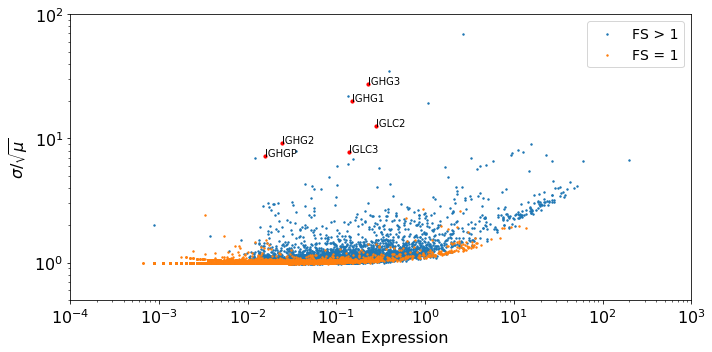

In [192]:
show_outliers = True
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()
plt.scatter(non_orphan_mean_list, non_orphan_dispersion_list, s=2, alpha=1, label='FS > 1')
plt.scatter(orphan_mean_list, orphan_dispersion_list, s=2, alpha=1, label='FS = 1')

if show_outliers:
    # orphan outliers
    outlier_indices = np.where(orphan_dispersion_list > 5)[0].tolist()
    plt.scatter(orphan_mean_list[outlier_indices], orphan_dispersion_list[outlier_indices], s=10, color='red')

    for index in outlier_indices:
        x = orphan_mean_list[index]
        y = orphan_dispersion_list[index]
        plt.text(x, y, mol_info.gene_names_array[gene_indices[index]].decode('ascii'))
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Mean Expression', fontsize=16)
ax.set_ylabel(r'$\sigma / \sqrt{\mu}$', fontsize=16)
ax.set_ylim((5e-1, 1e2))
ax.set_xlim((1e-4, 1e3))
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig('./plots/pbmc4k_dispersion_plot_orphan_non_orphan_with_outliers.pdf')

In [193]:
outlier_gene_indices = [gene_indices[index] for index in outlier_indices]
outlier_gene_names = [mol_info.gene_names_array[gene_index] for gene_index in outlier_gene_indices]

In [194]:
outlier_gene_indices

[32549, 32551, 23869, 23870, 23863, 23865]

In [195]:
outlier_gene_names

[b'IGLC2', b'IGLC3', b'IGHG1', b'IGHG3', b'IGHG2', b'IGHGP']

Observations with family size <= 1 for gene IGHG3: 62.5%
Observations with family size <= 1 for gene IGHG2: 86.6%
Observations with family size <= 1 for gene IGHGP: 94.6%


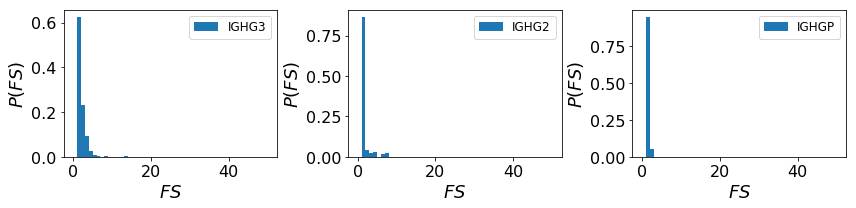

In [199]:
plot_umi_hist_for_genes(outlier_gene_names[3:6],
                        mol_info.gene_names_array,
                        full_umi_count_stats,
                        max_family_size_plot=50)
plt.savefig('./plots/pbmc4k_highly_dispersed_orphans_part_2.pdf')

In [5]:
from scipy import stats

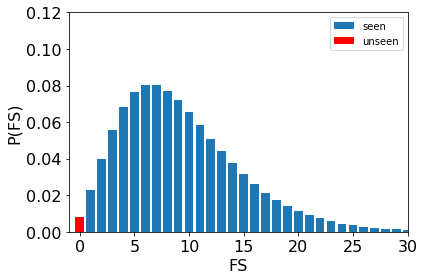

In [161]:
x = np.arange(0, 50)
y = [np.exp(stats.nbinom.logpmf(k, n=4, p=0.3)) for k in x]
plt.bar(x[1:], y[1:], label='seen')
plt.bar([x[0]], [y[0]], label='unseen', color='red')
plt.gca().set_xlabel('FS', fontsize=16)
plt.gca().set_ylabel('P(FS)', fontsize=16)
plt.legend()
plt.gca().set_xlim((-1, 30))
plt.ylim((0, 0.12))
plt.tight_layout()
plt.savefig('./plots/family_size_no_orphans.pdf')

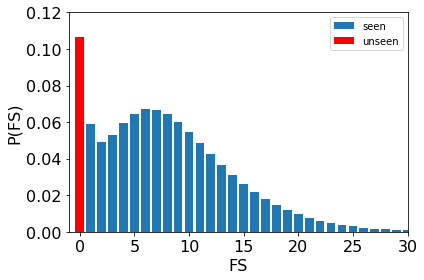

In [159]:
x = np.arange(0, 50)
y1 = np.asarray([np.exp(stats.nbinom.logpmf(k, n=4, p=0.3)) for k in x])
y2 = np.asarray([np.exp(stats.nbinom.logpmf(k, n=1, p=0.6)) for k in x])
y = y1 + 0.2*y2
y = y / np.sum(y)
plt.bar(x[1:], y[1:], label='seen')
plt.bar([x[0]], [y[0]], label='unseen', color='red')
plt.gca().set_xlabel('FS', fontsize=16)
plt.gca().set_ylabel('P(FS)', fontsize=16)
plt.legend()
plt.gca().set_xlim((-1, 30))
plt.ylim((0, 0.12))
plt.tight_layout()
plt.savefig('./plots/family_size_with_orphans.pdf')